In [1]:
import sys,os
#import setGPU
import numpy as np
import h5py
import random

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
import sklearn
from sklearn.metrics import confusion_matrix
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random

#sys.path.append(os.path.abspath(os.path.join('../ADgvae/')))
from pathlib import Path
from importlib import reload  
import os.path as osp
#sys.path.append(os.path.abspath(os.path.join('../../minisom/')))
#reload(minisom)
#from minisom import MiniSom

sys.path.append(os.path.abspath(os.path.join('../IDEC/')))
import data_utils.data_processing as data_proc
reload(data_proc)
from data_utils.data_processing import GraphDataset, DenseEventDataset
from training_utils.metrics import cluster_acc
from models.models import GraphAE, IDEC 
from training_utils.training import target_distribution,pretrain_ae_graph, train_test_ae_graph,train_test_idec_graph
from training_utils.activation_funcs  import get_activation_func

import torch
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data, Batch, DataLoader
from data_utils.data_processing import GraphDataset,DenseEventDataset
from training_utils.metrics import cluster_acc

from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

import matplotlib.colors as colors
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

from sklearn.manifold import TSNE

import matplotlib.colors as colors

sys.path.append(os.path.abspath(os.path.join('../')))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
filename_bg='/eos/cms/store/cmst3/user/egovorko/graph_data/background.h5'
in_file = h5py.File(filename_bg, 'r') 
#Counting nonzero rows in the arrays, to find maximum
res = np.count_nonzero(np.array(in_file['Particles'])[:,:,0],axis=-1)
res_uniques = np.unique(res,return_counts=True)

freq_counts_dict = {}
freq_counts_tot_dict = {}
total_entries = np.sum(res_uniques[1])
for freq,counts in zip(*res_uniques):
    freq_counts_dict[freq] = counts
    freq_counts_tot_dict[freq] = round(counts/total_entries,8)
print('Max number of particles, and frequency :')
print(freq_counts_dict)
print(freq_counts_tot_dict)


Max number of particles, and frequency :
{2: 5194015, 3: 2091174, 4: 646909, 5: 182327, 6: 53829, 7: 19902, 8: 9968, 9: 5622, 10: 3078, 11: 1535, 12: 725, 13: 318, 14: 77, 15: 11, 17: 1, 18: 1}
{2: 0.63268409, 3: 0.25472636, 4: 0.07880013, 5: 0.02220929, 6: 0.00655692, 7: 0.00242427, 8: 0.0012142, 9: 0.00068482, 10: 0.00037493, 11: 0.00018698, 12: 8.831e-05, 13: 3.874e-05, 14: 9.38e-06, 15: 1.34e-06, 17: 1.2e-07, 18: 1.2e-07}


In [50]:
#rearrange array such that we have all existing particles first
t = in_file['Particles'][:100,:,:]
COL = 0
DIM0 = 3
sorted_t = t[:, t[:, :, COL].argsort()][np.diag_indices(DIM0)][:,::-1,:]

array([[[53.15419388,  0.        , -0.5347867 ,  1.        ],
        [45.14450073, -1.06711662,  2.95747042,  2.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        

In [104]:
batch_size = 256
input_shape = [18,5]

DATA_PATH='/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/files/AD_event_based/graph_data/'
BG_NAME = 'background.h5'

in_file = h5py.File(DATA_PATH+BG_NAME, 'r') 

file_dataset = np.array(in_file['Particles'])
file_dataset =  data_proc.prepare_ad_event_based_dataset(file_dataset,1e5,shuffle=True)

prepared_dataset,datas =  data_proc.prepare_graph_datas(file_dataset,input_shape[0],n_top_proc = -1,connect_only_real=True)

test_dataset = GraphDataset(datas)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,drop_last=True) #,num_workers=5



Preparing dataset, check that the feature indexing corresponds to your dataset!
Preparing the dataset of 100000 events
Dataset of 100000 events prepared


/afs/cern.ch/user/n/nchernya/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [105]:
DATA_PATH='/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/files/AD_event_based/graph_data/'

SIG_NAMES = 'Ato4l,hChToTauNu,hToTauTau,LQ'.split(',') 
file_datasets_signals = []
for SIG_NAME in SIG_NAMES:

    SIG_NAME_file = 'sig_'+SIG_NAME+'.h5'
    filename_sig = DATA_PATH + SIG_NAME_file 
    in_file_sig = h5py.File(filename_sig, 'r') 
    file_dataset_sig = np.array(in_file_sig['Particles'])
    file_dataset_sig =  data_proc.prepare_ad_event_based_dataset(file_dataset_sig,1e5,shuffle=True,truth_name=SIG_NAME)
    file_datasets_signals.append(file_dataset_sig)

file_dataset_sig = np.concatenate(file_datasets_signals,axis=0)
prepared_dataset_sig,datas_sig =  data_proc.prepare_graph_datas(file_dataset_sig,input_shape[0],n_top_proc = -1,connect_only_real=True)
test_dataset_sig = GraphDataset(datas_sig)
test_loader_sig = DataLoader(test_dataset_sig, batch_size=batch_size, shuffle=False,drop_last=True) #,num_workers=5


Preparing dataset, check that the feature indexing corresponds to your dataset!
Preparing the dataset of 355969 events
Dataset of 355969 events prepared


In [106]:
import json 
import models.models as models
reload(models)
from models.models import load_DenseAE, load_IDEC, load_GraphAE 


load_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_AD_event_based/'
n_run = 'run_6'
load_dir+=n_run+'/'
#path_model_ae = load_dir+'/best_model_AE.pkl'
path_model_ae = load_dir+'/pretrained_AE_epoch_31.pkl'
path_params = load_dir+'parameters.json'
params_dict = json.loads(json.load(open(path_params)))

model_AE = load_GraphAE(params_dict, device, path_model_ae)


In [109]:
num_classes = 4
model_AE = model_AE.eval() 

pred_features = np.array([model_AE.forward(d.to(device))[0].data.cpu().numpy() for i,d in enumerate(test_loader)]) 
pred_features_met = np.array([model_AE.forward(d.to(device))[1].data.cpu().numpy() for i,d in enumerate(test_loader)]) 
latent_pred = np.array([model_AE.forward(d.to(device))[2].data.cpu().numpy() for i,d in enumerate(test_loader)])
latent_pred = np.reshape(latent_pred,(latent_pred.shape[0]*latent_pred.shape[1],latent_pred.shape[2]))

pred_features_sig = np.array([model_AE.forward(d.to(device))[0].data.cpu().numpy() for i,d in enumerate(test_loader_sig)])
pred_features_met_sig = np.array([model_AE.forward(d.to(device))[1].data.cpu().numpy() for i,d in enumerate(test_loader_sig)]) 
latent_pred_sig = np.array([model_AE.forward(d.to(device))[2].data.cpu().numpy() for i,d in enumerate(test_loader_sig)]) 
latent_pred_sig = np.reshape(latent_pred_sig,(latent_pred_sig.shape[0]*latent_pred_sig.shape[1],latent_pred_sig.shape[2]))


In [124]:
import  training_utils.losses as losses
reload(losses)
from training_utils.losses import chamfer_loss,huber_mask,categorical_loss,huber_loss,global_met_loss,chamfer_loss_split, ChamferLossSplit, ChamferLossSplitPID
import tqdm
from torch_geometric.utils import to_dense_batch


chamfer_loss_func = chamfer_loss_split

total_loss, total_reco_loss, total_pid_loss, total_met_loss, total_reco_zero_loss = 0.,0.,0.,0.,0.
chamfer_loss_module = ChamferLossSplit(reduction='none')
#chamfer_loss_module = ChamferLossSplitPID(pids = torch.arange(model.num_pid_classes))
chamfer_loss_func = torch.nn.DataParallel(chamfer_loss_module, device_ids=[0, 1],output_device=device)


def evaluate_losses(model,loader, device):
    total_simple_chamfer_loss, total_loss, total_reco_loss, total_pid_loss, total_met_loss = [],[],[],[],[]
    t = tqdm.tqdm(enumerate(loader),total=len(loader))
    for i, data in t:
        data = data.to(device)
        x = data.x.to(device)
        x_met = data.x_met.reshape((-1,model.input_shape_global)).to(device)
        batch_index = data.batch.to(device)

        with torch.no_grad():
            x_bar,x_met_bar, z = model(data)
        #use chamefer only to get indecies first 
        simple_chamfer_loss, xy_idx, yx_idx  = chamfer_loss(x[:,1:],x_bar[:,model.num_pid_classes:],batch_index,reduction='none')
        simple_chamfer_loss = torch.mean(simple_chamfer_loss,dim=-1)
        
        met_loss = torch.mean(global_met_loss(x_met, x_met_bar,reduction='none'),axis=-1)
        nll_loss = torch.nn.NLLLoss(reduction='none')#,weight=pid_weight)
        pid_loss = categorical_loss(x[:,0],x_bar[:,0:model.num_pid_classes],xy_idx, yx_idx,nll_loss) #target, reco
        pid_loss = torch.mean(to_dense_batch(pid_loss, batch_index)[0],axis=-1)

        target_dense = to_dense_batch(x[:,1:], batch_index)[0]
        reco_dense = to_dense_batch(x_bar[:,model.num_pid_classes:], batch_index)[0]
        in_pid_dense = to_dense_batch(x[:,0], batch_index)[0]
        out_pid_dense = to_dense_batch(x_bar[:,0:model.num_pid_classes].argmax(1), batch_index)[0]

        res = chamfer_loss_func(target_dense,reco_dense,in_pid_dense,out_pid_dense)
        if device!='cpu':
            res_gathered = torch.stack(res,dim=0)
            reco_loss,reco_zero_loss = res_gathered[0],res_gathered[1]

        loss = reco_loss +reco_zero_loss + pid_loss + met_loss #total loss with weights ? 
        total_loss.append(loss.clone())
        total_reco_loss.append(reco_loss+reco_zero_loss)
        total_pid_loss.append(pid_loss)
        total_met_loss.append(met_loss)
        total_simple_chamfer_loss.append(simple_chamfer_loss)
    return  torch.cat(total_simple_chamfer_loss).cpu().numpy(),\
            torch.cat(total_loss).cpu().numpy(),\
            torch.cat(total_reco_loss).cpu().numpy(),\
            torch.cat(total_pid_loss).cpu().numpy(),\
            torch.cat(total_met_loss).cpu().numpy()
        
total_simple_chamfer_loss,total_loss,total_reco_loss,total_pid_loss,total_met_loss = evaluate_losses(model_AE,test_loader,device)
total_simple_chamfer_loss_sig,total_loss_sig,total_reco_loss_sig,total_pid_loss_sig,total_met_loss_sig = evaluate_losses(model_AE,test_loader_sig,device)



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1390/1390 [01:33<00:00, 14.80it/s]


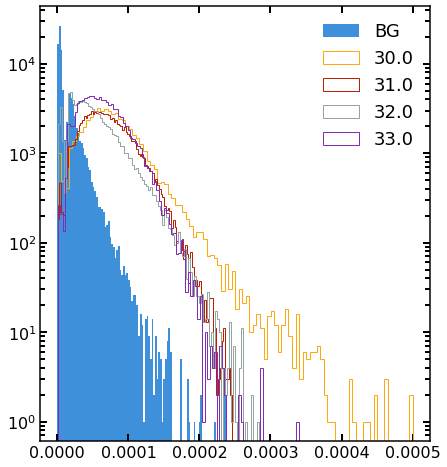

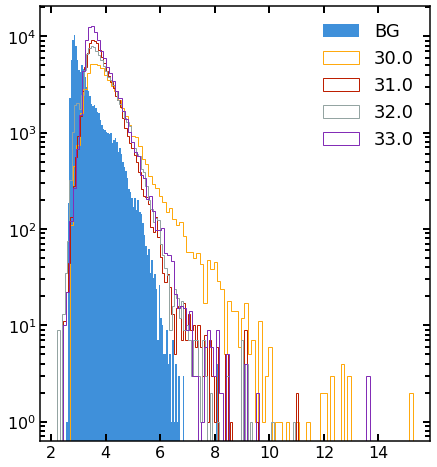

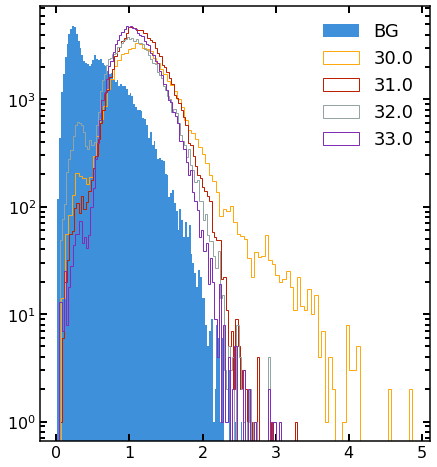

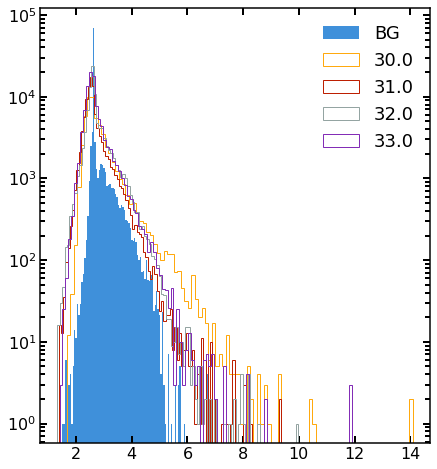

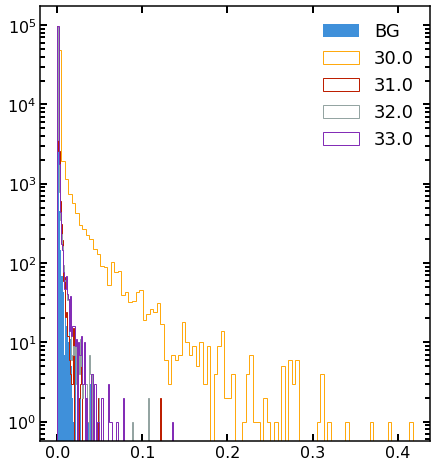

In [126]:
for loss_bg,loss_sig in zip([total_simple_chamfer_loss,total_loss,total_reco_loss,total_pid_loss,total_met_loss],[total_simple_chamfer_loss_sig,total_loss_sig,total_reco_loss_sig,total_pid_loss_sig,total_met_loss_sig]):
    plt.figure()
    _ = plt.hist(loss_bg,bins=100,label='BG')
    for sig in np.unique(true_labels_sig[:,0]):
        _ = plt.hist(loss_sig[true_labels_sig[:,0]==sig],bins=100,histtype='step',label=sig)
    plt.legend()
    plt.semilogy()

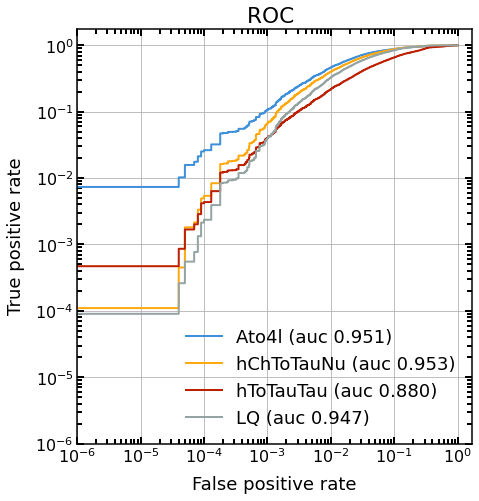

In [130]:
sys.path.append(os.path.abspath(os.path.join('../../sarewt_orig/')))
import vande.analysis.analysis_roc as ar
reload(ar)

neg_class_losses = [total_simple_chamfer_loss]*len(SIG_NAMES)
pos_class_losses = []
for sig in np.unique(true_labels_sig[:,0]):
    pos_class_losses.append(total_simple_chamfer_loss_sig[true_labels_sig[:,0]==sig])
    
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
test_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_AD_event_based/run_4/'
ar.plot_roc( neg_class_losses, pos_class_losses, legend=SIG_NAMES, title='ROC ',
            plot_name='test',xlim=1e-6,ylim=1e-6, fig_dir=None,log_x=True ,legend_loc='lower right')
plt.show()

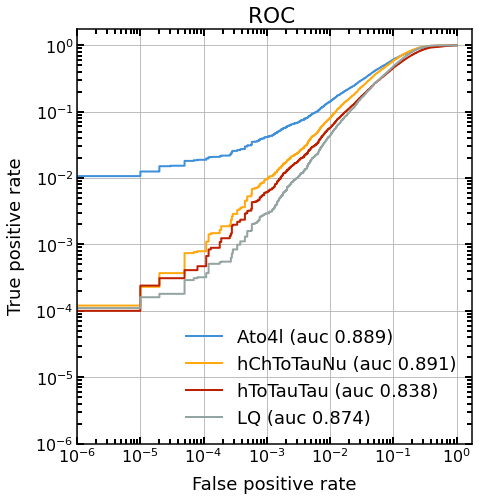

In [131]:
sys.path.append(os.path.abspath(os.path.join('../../sarewt_orig/')))
import vande.analysis.analysis_roc as ar
reload(ar)

neg_class_losses = [total_reco_loss]*len(SIG_NAMES)
pos_class_losses = []
for sig in np.unique(true_labels_sig[:,0]):
    pos_class_losses.append(total_reco_loss_sig[true_labels_sig[:,0]==sig])
    
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
test_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_AD_event_based/run_4/'
ar.plot_roc( neg_class_losses, pos_class_losses, legend=SIG_NAMES, title='ROC ',
            plot_name='test',xlim=1e-6,ylim=1e-6, fig_dir=None,log_x=True ,legend_loc='lower right')
plt.show()

In [110]:
def reshape_to_dense_batch(features,batch_size):
    s0 = features.shape[0]
    s1 = features.shape[1]
    s2 = features.shape[2]
    features = features.reshape((int(s0*batch_size),int(s1/batch_size),s2))
    return features


def prepare_final_output_features(pred_features,pred_features_met,num_classes):
    pr_f = np.expand_dims(np.argmax(np.exp(pred_features[:,:,0:num_classes]),axis=-1),axis=-1)
    pred_features_small = np.concatenate([pr_f,pred_features[:,:,num_classes:]],axis=-1)
    pred_features_merged_batch = pred_features_small.reshape(-1,pred_features_small.shape[2])
     
    pred_features_per_batch = reshape_to_dense_batch(pred_features_small,batch_size)                                   
    pred_met = pred_features_met.reshape((-1,pred_features_met.shape[2]))
    
    return pred_features_merged_batch, pred_features_per_batch, pred_met
    

def prepare_final_input_features(prepared_dataset):
    len_drop_last = batch_size*(len(prepared_dataset)//batch_size)
    t_per_batch = prepared_dataset[:len_drop_last,1:,1:]
    t = t_per_batch.reshape(-1,t_per_batch.shape[-1])
    t_met = prepared_dataset[:len_drop_last,0:1,[2,4,5]]
    t_met = t_met.reshape((t_met.shape[0])*t_met.shape[1],t_met.shape[2])
    true_labels = prepared_dataset[:len_drop_last,0,[0]]
    return t, t_per_batch, t_met, true_labels
        
          
pred_features_comb, pred_features_per_batch, pred_met = prepare_final_output_features(pred_features,pred_features_met,num_classes)
pred_features_comb_sig, pred_features_per_batch_sig, pred_met_sig = prepare_final_output_features(pred_features_sig,pred_features_met_sig,num_classes)

input_feats,input_feats_per_batch, input_feats_met,true_labels = prepare_final_input_features(prepared_dataset)
input_feats_sig,input_feats_per_batch_sig, input_feats_met_sig,true_labels_sig = prepare_final_input_features(prepared_dataset_sig)
                                      
                       

In [16]:
true_labels_sig[:,0]

array([30., 30., 30., ..., 33., 33., 33.])

In [ ]:
_ = plt.hist(outs[0],bins=100,histtype='step',label='BG')
for sig in np.unique(true_labels_sig[:,0]):
    _ = plt.hist(outs_sig[0][true_labels_sig[:,0]==sig],bins=100,histtype='step',label=sig)
plt.legend()
plt.semilogy()

In [ ]:
sys.path.append(os.path.abspath(os.path.join('../../sarewt_orig/')))
import vande.analysis.analysis_roc as ar
reload(ar)

neg_class_losses = [outs[0]]*len(SIG_NAMES)
pos_class_losses = []
for sig in np.unique(true_labels_sig[:,0]):
    pos_class_losses.append(outs_sig[0][true_labels_sig[:,0]==sig])
    
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
test_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_AD_event_based/run_4/'
ar.plot_roc( neg_class_losses, pos_class_losses, legend=SIG_NAMES, title='ROC ',
            plot_name='test',xlim=1e-6, fig_dir=None,log_x=True )
plt.show()

In [ ]:
def chamfer_loss_numpy(target, reco):
    diff = np.expand_dims(target,2) - np.expand_dims(reco,1)
    dist =np.sqrt(np.sum(diff**2,axis=-1))
    #eucl for all particles that are not 0 , normal chamfer 
    idx_min_dist_xy = np.argmin(dist, axis=-1)
    idx_min_dist_yx = np.argmin(dist, axis=-2)
    min_dist_xy = np.min(dist, axis=-1)
    min_dist_yx = np.min(dist, axis=-2)
    eucl_non_zero =  1./2*(np.sum(min_dist_xy,axis=-1) + np.sum(min_dist_yx,axis=-1))
    return eucl_non_zero,idx_min_dist_xy,idx_min_dist_yx
    

pred_features_full = reshape_to_dense_batch(pred_features,batch_size)
outs = chamfer_loss_numpy(input_features[:,:,1:],pred_features_per_batch[:,:,model_AE.num_pid_classes:])
outs_sig = chamfer_loss_numpy(input_features_sig[:,:,1:],pred_features_per_batch_sig[:,:,model_AE.num_pid_classes:])

In [142]:
class CustomHuberLoss:
    def __init__(self, delta = 1.0, reduction ='mean' ):
        self.delta = delta
        self.reduction = reduction

    def __call__(self, difference):
        errors = torch.abs(difference)

        mask = errors < self.delta
        res = (0.5 * mask * (torch.pow(errors,2))) + ~mask *(self.delta*(errors-0.5*self.delta))
        if self.reduction=='mean':
            return torch.mean(res)
        else:
            return torch.sum(res)
        
    def call_numpy(self,difference):
        errors = np.abs(difference)

        mask = errors < self.delta
        res = (0.5 * mask * (np.power(errors,2))) + ~mask *(self.delta*(errors-0.5*self.delta))
        if self.reduction=='mean':
            return np.mean(res,axis=-1)
        else:
            return np.sum(res,axis=-1)
        
def global_met_loss_numpy(target, reco):
    #this custom class is not needed anymore, we can just use directly Huber. it was needed for applying cyclic operation on delta phi
    diff = target-reco

    loss_fnc = CustomHuberLoss(delta=10.0)
    loss = 2*(loss_fnc.call_numpy(diff)) #2* because in Huber loss there is a factor 1/2
    return loss

In [143]:
outs_met = global_met_loss_numpy(input_met,pred_met)

In [151]:
from training_utils.losses import categorical_loss
nll_loss = torch.nn.NLLLoss(reduction='none')
def categorical_loss2(target, reco,xy_idx, yx_idx,loss_fnc):
    get_x = target[xy_idx.long()].long()
    get_y = reco[yx_idx.long()]

    #reco : get_x #reco - the closest input  to the output 
    #target : get_y # :target - the closest output to the input
    #first argument NN output, second argument is true labels

    print(xy_idx.shape,yx_idx.shape)
    print(reco.shape,target.shape)
    print(reco.shape,get_x.shape, get_y.shape, target.shape)
    loss = loss_fnc(reco,get_x) + loss_fnc(get_y,target.long()) #output loss per graph node
    return loss

pid_loss = categorical_loss2(torch.tensor(input_features[:,:,0]),torch.tensor(pred_features_full[:,:,0:model_AE.num_pid_classes]),torch.tensor(outs[1]), torch.tensor(outs[2]),nll_loss) #target, reco
        

torch.Size([9984, 18]) torch.Size([9984, 18])
torch.Size([9984, 18, 4]) torch.Size([9984, 18])
torch.Size([9984, 18, 4]) torch.Size([9984, 18, 18]) torch.Size([9984, 18, 18, 4]) torch.Size([9984, 18])


RuntimeError: Expected target size [9984, 4], got [9984, 18, 18]

In [135]:
pred_features_full[:,:,0:model_AE.num_pid_classes].shape

(9984, 18, 4)

In [18]:
input_feats.shape

(9984, 18, 5)

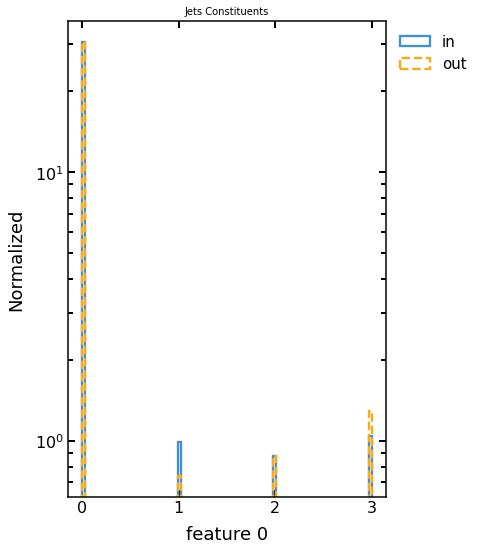

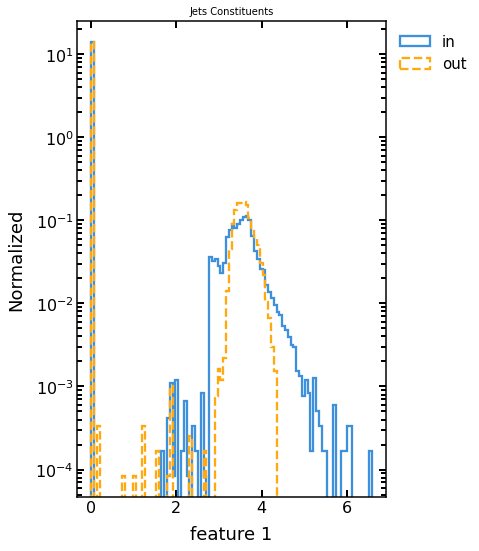

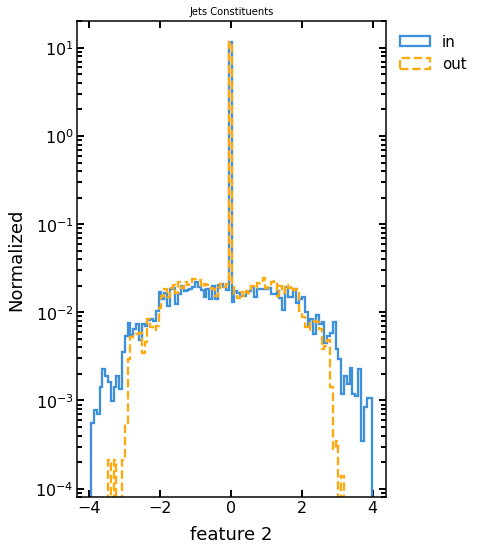

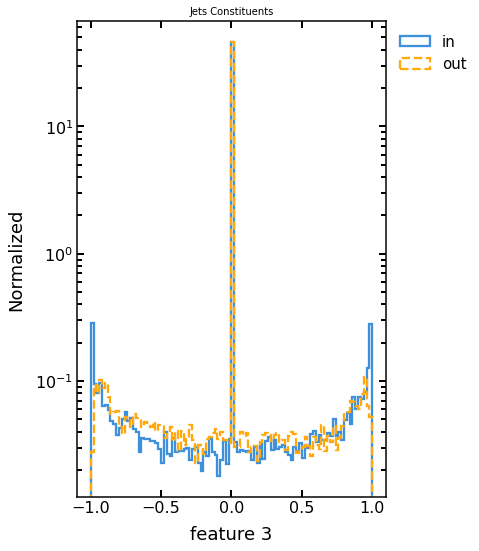

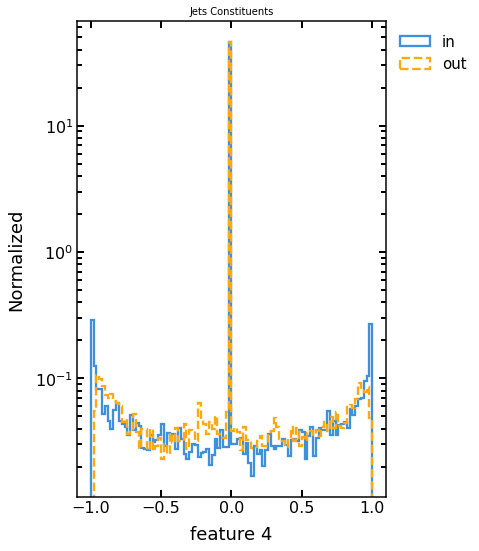

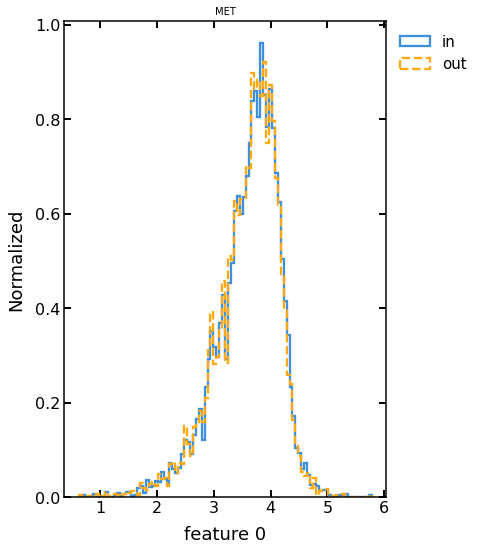

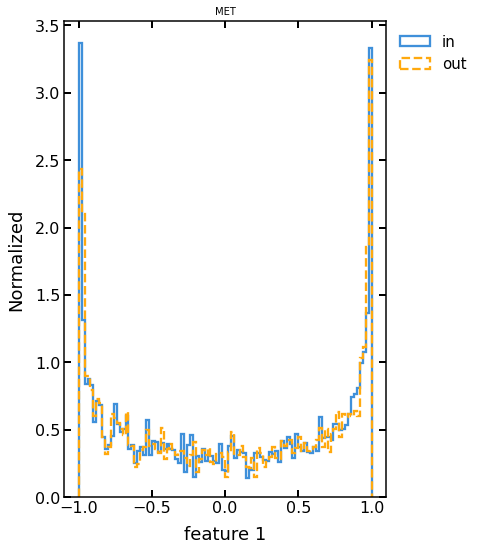

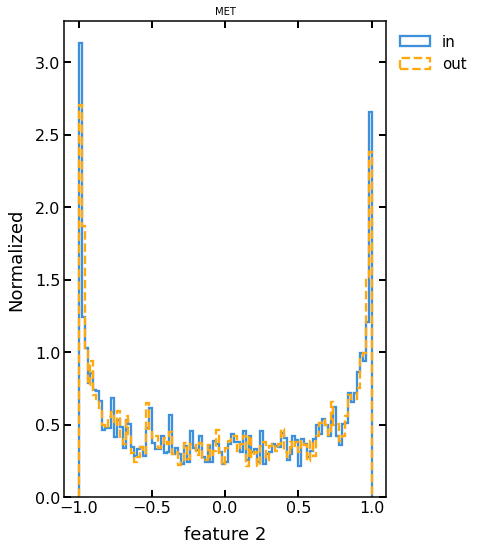

In [22]:
sys.path.append(os.path.abspath(os.path.join('../../')))
import vande.util.util_plotting as vande_plot
reload(vande_plot)


vande_plot.plot_features([input_feats,pred_features_comb], 'feature' ,
                             'Normalized' , 'Jets Constituents', 
                             plotname='test',
                             legend=['in','out'],
                              ylogscale=True)
    
vande_plot.plot_features([input_feats_met,pred_met], 'feature' ,
                             'Normalized' , 'MET', 
                             plotname='test',
                             legend=['in','out'],
                              ylogscale=False)

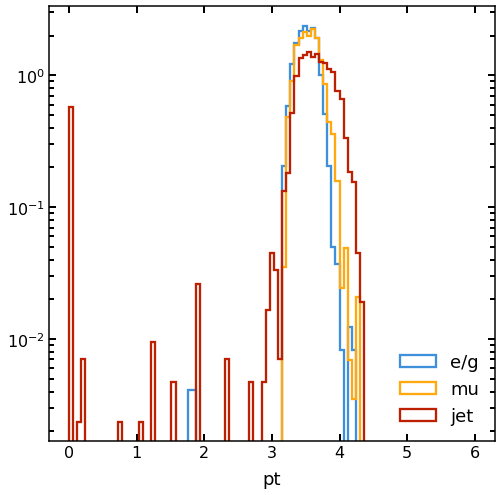

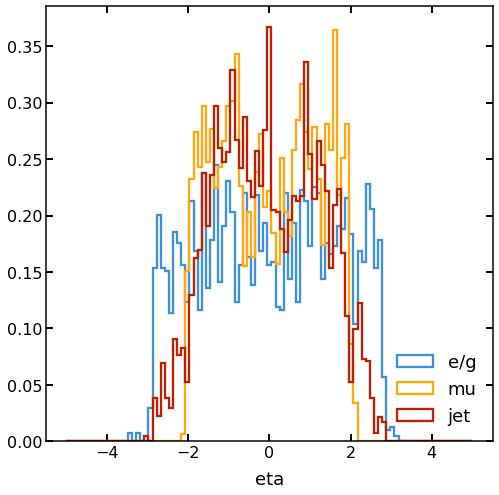

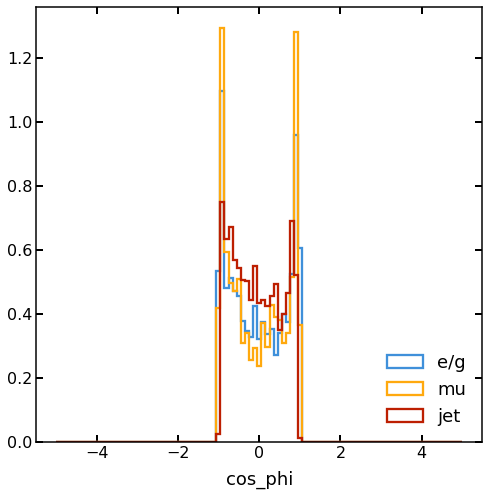

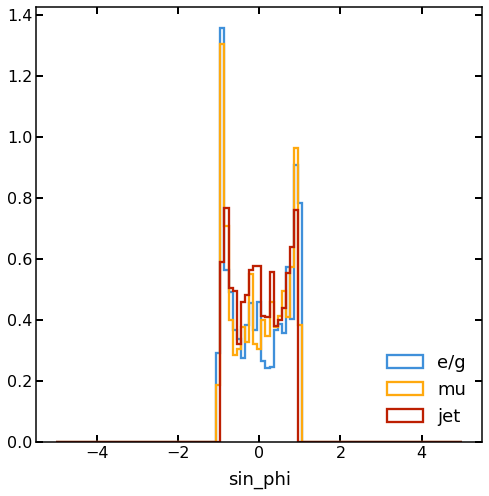

In [23]:
for i,name in zip([1,2,3,4],'pt,eta,cos_phi,sin_phi'.split(',')):
    plt.figure(figsize=(8,8))
    bins = np.linspace(-5,5,100)
    if i==1:
        bins = np.linspace(0,6,100)
        plt.semilogy()
    kwargs={'linewidth':2.3, 'fill':False, 'density':True,'histtype':'step'}
    #for pid_name, pid in zip(['0','b/j','mu','e/g'],[0,1,2,3]):
    #for pid_name, pid in zip(['0','b','j','mu','g','e'],[0,1,2,3,4,5]):
    for pid_name, pid in zip(['e/g','mu','jet'],[1,2,3]):
        mask = pred_features_per_batch[:,:,0]==pid
        _ = plt.hist(pred_features_per_batch[:,:,i][mask],bins=bins,**kwargs,label=pid_name)
    plt.xlabel(name)
    plt.legend(loc='lower right')
    #plt.semilogy()

Text(0, 0.5, 'sin(phi)')

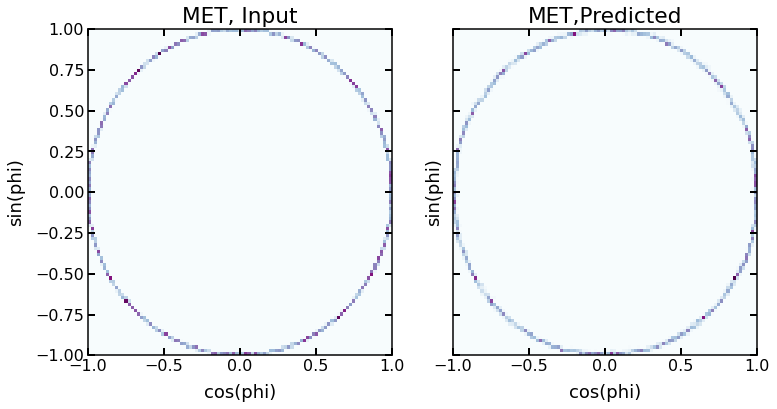

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6),sharey=True)
binning = np.linspace(-1,1,100)
_ = axs[0].hist2d(input_feats_met[:,1],input_feats_met[:,2],bins=[binning,binning], cmap=plt.cm.BuPu)
axs[0].set_title('MET, Input')
axs[0].set_xlabel('cos(phi)')
axs[0].set_ylabel('sin(phi)')
_ = axs[1].hist2d(pred_met[:,1],pred_met[:,2],bins=[binning,binning], cmap=plt.cm.BuPu)
axs[1].set_title('MET,Predicted')
axs[1].set_xlabel('cos(phi)')
axs[1].set_ylabel('sin(phi)')

Text(0, 0.5, 'sin(phi)')

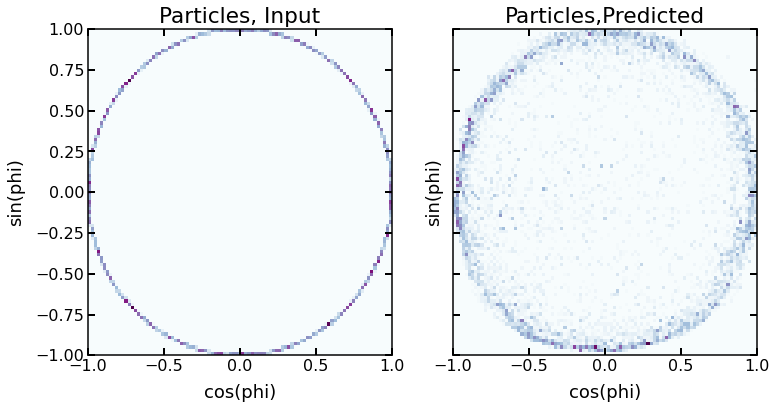

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6),sharey=True)
binning = np.linspace(-1,1,100)
mask = input_feats[:,0]!=0
_ = axs[0].hist2d(input_feats[:,-2][mask],input_feats[:,-1][mask],bins=[binning,binning], cmap=plt.cm.BuPu)
axs[0].set_xlabel('cos(phi)')
axs[0].set_ylabel('sin(phi)')
axs[0].set_title('Particles, Input')
mask = pred_features_comb[:,0]!=0
_ = axs[1].hist2d(pred_features_comb[:,-2][mask],pred_features_comb[:,-1][mask],bins=[binning,binning], cmap=plt.cm.BuPu)
axs[1].set_title('Particles,Predicted')
axs[1].set_xlabel('cos(phi)')
axs[1].set_ylabel('sin(phi)')